# Alibi Detect のオンラインMMD（MMDDriftOnline）を「センサ時系列の逐次監視」で使う手順（具体行列つき・省略なし）
（数式は $...$。JupyterのMarkdownセルにそのまま貼れる形）

参照（一次情報）
- 公式解説（Online MMD Drift）：https://docs.seldon.ai/alibi-detect/cd/methods/online/onlinemmddrift
- 公式API（MMDDriftOnline）：https://docs.seldon.ai/alibi-detect/api-reference/cd/mmd_online

---

## ステップ1：逐次入力の「1サンプル」$x_t$ を決める
オンラインMMDは、時刻 $t$ ごとに 1つのサンプル $x_t$ を受け取り、`predict(x_t)` を呼ぶたびに内部状態（直近の窓など）を更新して判定する。

ここでの最重要は「$x_t$ を何にするか」。これが決まると、`window_size` は「何サンプルぶんを見るか」になり、結果として「何秒・何サイクルぶんを見るか」が一意に決まる。

具体例として、特徴量が3列（$d=3$）のケースに統一する。
1サンプルを $x_t=[f_1,f_2,f_3]\in\mathbb{R}^3$ とし、例えば次のように意味付けする。
- $f_1$：圧力の平均（安定）
- $f_2$：振動のRMS（安定）
- $f_3$：高周波帯パワー（摩耗等で増えやすい、ここがドリフトする想定）

---

## ステップ2：参照データ $X_{\mathrm{ref}}$（正常）を行列として作る
参照は「正常運転のサンプルを縦に並べた行列」で、形は $(N_{\mathrm{ref}}, d)$。

ミニ例として $N_{\mathrm{ref}}=10$, $d=3$ の参照行列を明示する（値は例）。

$$
X_{\mathrm{ref}}=
\begin{bmatrix}
10.0 & 0.50 & 0.55 \\
10.1 & 0.48 & 0.52 \\
9.9  & 0.51 & 0.57 \\
10.2 & 0.49 & 0.54 \\
10.0 & 0.50 & 0.56 \\
9.8  & 0.52 & 0.53 \\
10.1 & 0.47 & 0.51 \\
10.0 & 0.50 & 0.55 \\
10.2 & 0.49 & 0.58 \\
9.9  & 0.51 & 0.54
\end{bmatrix}
$$

この行列は「正常時の3次元点群」を表す。3D散布図で見れば、点がある範囲にまとまった“雲”になる。

---

## ステップ3：「学習」に相当するのは しきい値（threshold）の校正
MMDDriftOnlineは分類器のように重みを学習するのではなく、各時刻で
1) 参照点群 $X_{\mathrm{ref}}$ と、直近窓点群 $Y_t$ の分布差を $MMD^2$（テスト統計量）として計算し、
2) その値が「しきい値」を超えたら `is_drift=1`
という運用をする。

この「しきい値」を決めるのに登場するのが `ert` と `n_bootstraps`。

### 3.1 `ert`（Expected Run Time）
`ert` は「ドリフトが無いのに誤検知が出るまでの平均ステップ数」を仕様として先に与えるための量。
例えば 1秒ごとに `predict` を呼ぶなら、`ert=3600` は「正常時、平均1時間に1回誤報」を意味する（ステップ=秒）。

ここまでなら直感は作りやすいが、次が本題。

### 3.2 `n_bootstraps` は何をするのか（ここが核心）
`n_bootstraps=B` は、しきい値（threshold）を作るために「ドリフト無しの状況を $B$ 回シミュレーションする回数」だと思ってよい。

やりたいことは次の1行に尽きる。
「ドリフトが無いなら $MMD^2$ はだいたいどれくらいの値になるのか」という分布を作り、その上側の“めったに出ない大きい値”をしきい値にする。

その“分布”を作る方法が bootstrap（ブートストラップ）で、実際にやっている作業イメージは次の通り。

(準備) `window_size=W` を決める。

(ブートストラップ $b=1..B$ の各回でやること)
- 参照行列 $X_{\mathrm{ref}}$ の行から、サイズ $W$ の疑似テスト窓 $Y^{(b)}$ を作る
  典型的には「$X_{\mathrm{ref}}$ から $W$ 行を（復元ありで）取り出して並べる」などで作る
- $s^{(b)}=MMD^2(X_{\mathrm{ref}},Y^{(b)})$ を計算する
- これを $B$ 回繰り返して $s^{(1)},...,s^{(B)}$ を集める

こうして得た $\{s^{(b)}\}$ は「ドリフト無しなら $MMD^2$ はこの範囲に出やすい」という経験分布になる。

しきい値は、この経験分布の上側分位点（上位○%）として決める。
ここで `ert` が効く。

直感的な近似として、
「1ステップごとの誤警報確率を $p\approx 1/\mathrm{ERT}$ にしたい」
とすると、しきい値は
$\text{threshold} \approx \text{Quantile}_{1-p}(\{s^{(b)}\})$
のように「上位 $p$ の境界」に置くことになる。

`n_bootstraps` が小さいと何が起きるか。
分位点（上側の境界）推定が不安定になる。つまり threshold がぶれて、実際の誤警報頻度（実現ERT）が狙いから外れやすい。
`n_bootstraps` を大きくすると、上側分位点の推定が安定して、狙ったERTに近づきやすい。

これが公式APIで「`n_bootstraps` を増やすほど狙ったERTをより正確にターゲットできる」「理想的にはERTより1桁以上大きい」と説明されている理由になる。
参照：https://docs.seldon.ai/alibi-detect/api-reference/cd/mmd_online

### 3.3 3特徴量で「1つの特徴量だけドリフト」のとき、窓行列はどう見えるか
`window_size=W=5` とする。
時刻 $t$ のテスト窓行列は $Y_t=[x_{t-4},...,x_t]$ を縦に並べた $(5,3)$ 行列。

ドリフト前（$f_3$ も正常域）の窓例（値は例）：
$$
Y_{\text{pre}}=
\begin{bmatrix}
10.0 & 0.49 & 0.54 \\
10.1 & 0.50 & 0.56 \\
9.9  & 0.48 & 0.52 \\
10.2 & 0.51 & 0.57 \\
10.0 & 0.49 & 0.55
\end{bmatrix}
$$


ドリフト後（$f_1,f_2$ はほぼ同じだが $f_3$ だけ上にずれる）の窓例：
$$
Y_{\text{post}}=
\begin{bmatrix}
10.0 & 0.49 & 0.95 \\
10.1 & 0.50 & 1.05 \\
9.9  & 0.48 & 1.00 \\
10.2 & 0.51 & 1.10 \\
10.0 & 0.49 & 0.98
\end{bmatrix}
$$


3D散布図で見ると、$Y_{\text{post}}$ の点群は $f_1,f_2$ 方向では重なるのに $f_3$ 方向だけ“持ち上がる”。
オンラインMMDは、この「点群の雲の位置や形のズレ」を $MMD^2$ として数値化し、threshold 超えでドリフトと判断する。

---

## ステップ4：`window_size`（窓）の意味を「行列」で理解する（スライディング）
`window_size=W` は、直近 $W$ 個の $x_t$ を縦に並べた窓行列 $Y_t$ を使う、という意味。
スライディングなので、次の時刻では 1行が落ちて 1行が追加される。

$Y_t=$
[
 $x_{t-W+1}$,
 $\dots$,
 $x_t$
]

小さい窓は大きい変化に速く反応しやすく、大きい窓は小さい変化（じわじわ）を拾いやすい、という方向性が公式解説にある。

参照：https://docs.seldon.ai/alibi-detect/cd/methods/online/onlinemmddrift

---

## ステップ5：`predict` の返り値をログに残して「いつ変わったか」を後から追う
運用では、各時刻で少なくとも次を保存すると「後から確認」ができる。
`time`：投入したサンプル数（内部時刻）
`test_stat`：$MMD^2$
`threshold`：しきい値
`is_drift`：0/1

この4つが揃うと、後から
「いつから $MMD^2$ が threshold に近づき、いつ超えたか」
がそのまま見える。

---

## ステップ6：全体像（1行で）
固定の参照行列 $X_{\mathrm{ref}}$ を作る。
`n_bootstraps` 回のブートストラップで「ドリフト無し時の $MMD^2$ 分布」を作り、`ert` に合わせて threshold を校正する。
運用では毎時刻 $x_t$ を入れて窓 $Y_t$ を更新し、$MMD^2(X_{\mathrm{ref}},Y_t)$ が threshold を超えたらドリフト。


In [16]:
# 最小：合成データ(2000個) → 学習(参照)とテスト(逐次)に分割 → Alibi(Online MMD)でドリフト検知
# 依存: !pip install "alibi-detect[tensorflow]"

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

from alibi_detect.cd import MMDDriftOnline

rng = np.random.default_rng(0)

In [17]:

# ============================================================
# 0) 合成データを作る（3次元特徴量）
#    - f1, f2: ずっと同じ正規分布
#    - f3: カイ二乗分布をベースにして「歪んだ分布」を作る
#          → 途中で df を変えると「分布形状の変化（ドリフト）」を作りやすい
# ============================================================

# 乱数の種（再現性のため）
rng = np.random.default_rng(0)

N_total = 2000  # 全サンプル数

# f1: 平均10, 標準偏差0.5 の正規分布
f1 = rng.normal(loc=10.0, scale=0.5, size=N_total)

# f2: 平均0.50, 標準偏差0.05 の正規分布
f2 = rng.normal(loc=0.50, scale=0.05, size=N_total)

# f3（基準）:
#   chi-square(df=4) は平均=4, 分散=8
#   まず平均0・分散1に標準化してから、平均0.55・標準偏差0.03程度に整形する
z_base = (rng.chisquare(df=4, size=N_total) - 4.0) / np.sqrt(8.0)  # 平均0, 分散1
f3_base = 0.55 + 0.03 * z_base                                     # 平均0.55付近, ばらつき0.03付近

# 3つの特徴量を列方向にまとめて (N_total, 3) の配列にする
# float32 にしてメモリを軽くする（深い意味はない）
X_all = np.column_stack([f1, f2, f3_base]).astype(np.float32)

# ============================================================
# 1) 参照データ（正常）とテストデータ（逐次入力用）に分割
#    - X_ref : 最初の N_ref 個（正常のみ）
#    - X_test: 残り（途中から f3 の分布を変える → ドリフトを仕込む）
# ============================================================

N_ref = 800
X_ref = X_all[:N_ref].copy()       # 参照（正常）データ
X_test = X_all[N_ref:].copy()      # テストデータ

# テストの中で、ここから先を「ドリフト後」にする（真の変化点）
T_star = 600
n_test = X_test.shape[0]

# f3（ドリフト）:
#   chi-square(df=12) は平均=12, 分散=24
#   同様に平均0・分散1に標準化し、同じスケール 0.03 を掛ける
#   さらに +0.12 で平均も上方シフト（検知しやすくする）
z_drift = (rng.chisquare(df=12, size=n_test - T_star) - 12.0) / np.sqrt(24.0)
f3_drift = (0.55 + 0.03 * z_drift) + 0.03

# テストデータの f3（列2）だけ、変化点以降をドリフト後分布に差し替える
X_test[T_star:, 2] = f3_drift.astype(np.float32)

# ============================================================
# 2) 標準化（参照データで平均・標準偏差を作る）
#    重要:
#      - 正規化/標準化の統計量（平均・標準偏差）は X_ref だけで作る
#      - X_test 全体で作ると、ドリフト後の情報が混ざって「漏れ」になる
# ============================================================

# 参照データの列ごとの平均・標準偏差
mu = X_ref.mean(axis=0)
sd = X_ref.std(axis=0) + 1e-12     # 0割回避のため小さい値を足す

# 参照基準で両方を標準化（zスコア化）
X_ref = (X_ref - mu) / sd
X_test = (X_test - mu) / sd


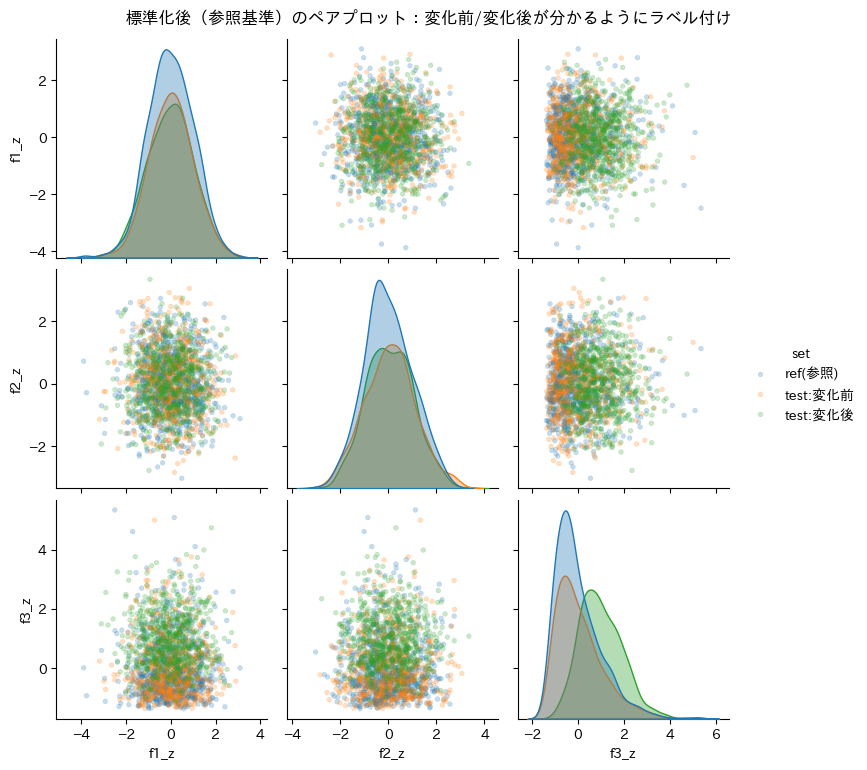

set
ref(参照)     800
test:変化前    600
test:変化後    600
Name: count, dtype: int64

In [18]:

# ============================================================
# 3) 可視化用にラベル付きのDataFrameにまとめる
#    - ref(参照)
#    - test:変化前（T_starより前）
#    - test:変化後（T_star以降）
# ============================================================

# 列名（標準化後なので _z を付ける）
cols = ["f1_z", "f2_z", "f3_z"]

# 参照データ
df_ref = pd.DataFrame(X_ref, columns=cols)
df_ref["set"] = "ref(参照)"

# テスト（変化前）
df_pre = pd.DataFrame(X_test[:T_star], columns=cols)
df_pre["set"] = "test:変化前"

# テスト（変化後）
df_post = pd.DataFrame(X_test[T_star:], columns=cols)
df_post["set"] = "test:変化後"

# 3つを連結
df = pd.concat([df_ref, df_pre, df_post], ignore_index=True)

# ============================================================
# 4) seaborn の pairplot で散布図行列を作る
#    - 非対角: 散布図（半透明にして重なりを見やすく）
#    - 対角  : KDE（各特徴量の1次元密度）
#    - hue   : set（ラベル）で色分け
# ============================================================

g = sns.pairplot(
    df,
    vars=cols,                      # 可視化する特徴量（3次元なので3×3の行列）
    hue="set",                      # ラベルで色分け
    diag_kind="kde",                # 対角はKDE（密度曲線）
    plot_kws={
        "alpha": 0.25,              # 点を半透明にして密集度が分かるように
        "s": 12,                    # 点のサイズ
        "edgecolor": None           # 点の縁を消して見やすく（環境によって警告が出る場合あり）
    },
    diag_kws={
        "fill": True,               # KDEの下を塗る
        "alpha": 0.35               # 塗りの透明度
    }
)

# 図のタイトル
g.fig.suptitle(
    "標準化後（参照基準）のペアプロット：変化前/変化後が分かるようにラベル付け",
    y=1.02
)

plt.show()

# ============================================================
# 5) 各ラベルのサンプル数を確認（想定通りかチェック）
# ============================================================
df["set"].value_counts()


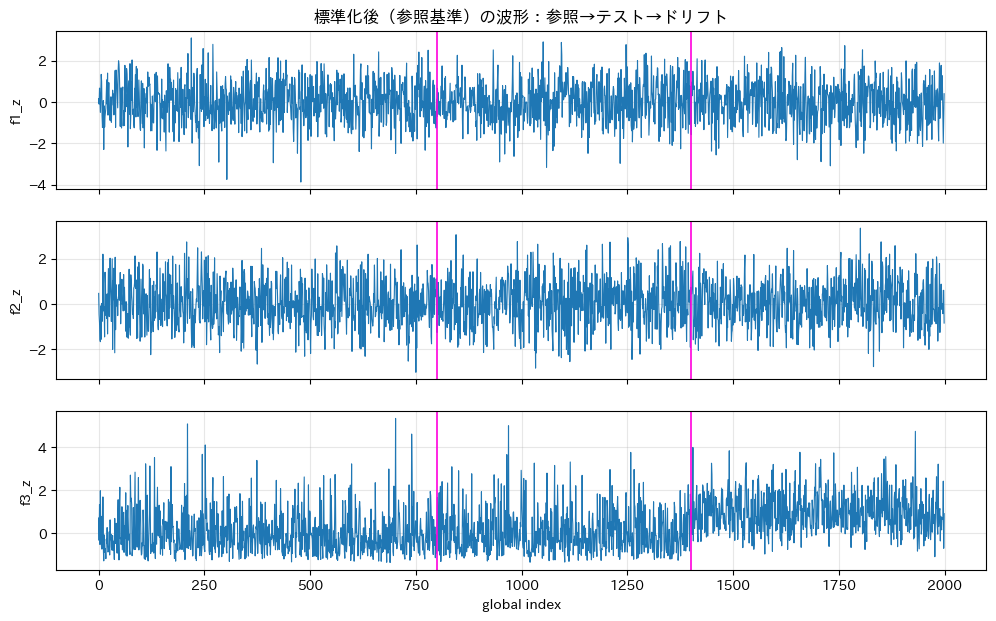

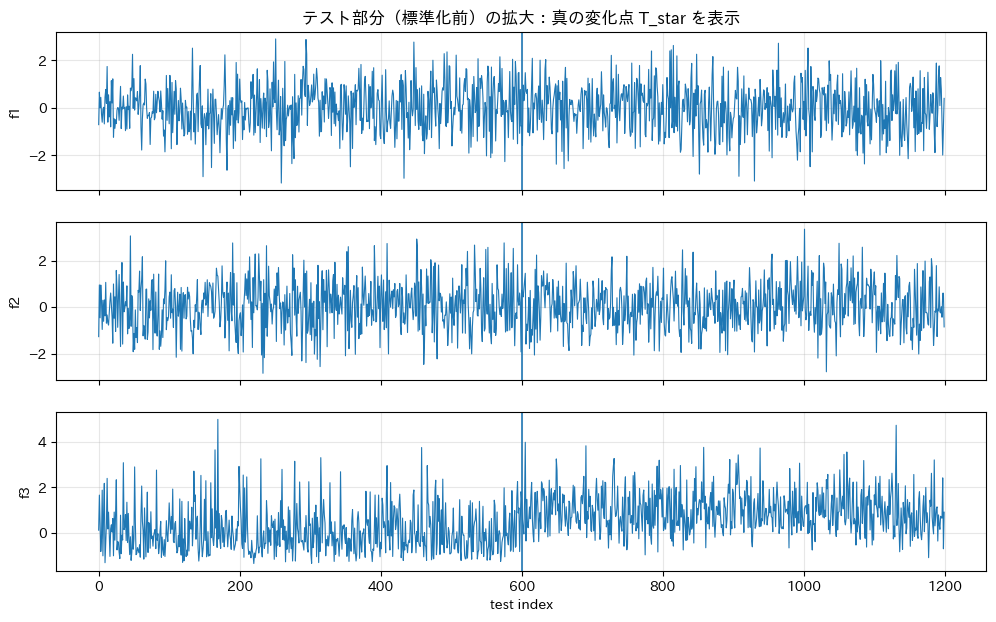

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 前提：
#   X_ref  : (N_ref, 3) 参照（正常）
#   X_test : (N_test, 3) テスト（途中でドリフト）
#   N_ref, T_star が定義済み
#
# 注意：
#   すでに X_ref, X_test を標準化で上書きしている場合に備えて、
#   「元データ」を残していないなら、標準化前の配列を別名で保持してください。
# ============================================================

# -----------------------------
# 0) グローバル時系列を作る（参照→テストを連結）
# -----------------------------
X_stream = np.vstack([X_ref, X_test])          # (N_ref + N_test, 3)
t = np.arange(X_stream.shape[0])              # global index

# 参照/テストの境界と、真の変化点（global）
g_ref_end = N_ref
g_drift   = N_ref + T_star

# -----------------------------
# 1) 元データ（標準化前）の「波形」を表示
#    - 3変数を上下3段で表示（スケールが違うので見やすい）
# -----------------------------
# names = ["f1", "f2", "f3"]

# fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

# for k in range(3):
#     axes[k].plot(t, X_stream[:, k], linewidth=0.8)
#     axes[k].axvline(g_ref_end, linewidth=1.2)   # 参照→テスト境界
#     axes[k].axvline(g_drift, linewidth=1.2)     # 真の変化点
#     axes[k].set_ylabel(names[k])
#     axes[k].grid(True, alpha=0.3)

# axes[0].set_title("元データ（標準化前）の波形：参照→テスト→ドリフト")
# axes[-1].set_xlabel("global index")
# plt.show()

# -----------------------------
# 2) 標準化後の「波形」も表示（3変数が同じスケールで比較しやすい）
#    - 参照だけで平均/標準偏差を作る（漏れ防止）
# -----------------------------
mu = X_ref.mean(axis=0)
sd = X_ref.std(axis=0) + 1e-12

X_ref_z  = (X_ref  - mu) / sd
X_test_z = (X_test - mu) / sd
X_stream_z = np.vstack([X_ref_z, X_test_z])

fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

for k in range(3):
    axes[k].plot(t, X_stream_z[:, k], linewidth=0.8)
    axes[k].axvline(g_ref_end, linewidth=1.2, color="#FF00DD")  # 参照→テスト境界（オレンジ色）
    axes[k].axvline(g_drift, linewidth=1.2, color="#FF00DD")
    axes[k].set_ylabel(names[k] + "_z")
    axes[k].grid(True, alpha=0.3)

axes[0].set_title("標準化後（参照基準）の波形：参照→テスト→ドリフト")
axes[-1].set_xlabel("global index")
plt.show()

# -----------------------------
# 3) （任意）テスト部分だけ拡大表示（変化点周辺を見たい場合）
# -----------------------------
# t_test = np.arange(X_test.shape[0])

# fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
# for k in range(3):
#     axes[k].plot(t_test, X_test[:, k], linewidth=0.8)
#     axes[k].axvline(T_star, linewidth=1.2)
#     axes[k].set_ylabel(names[k])
#     axes[k].grid(True, alpha=0.3)

# axes[0].set_title("テスト部分（標準化前）の拡大：真の変化点 T_star を表示")
# axes[-1].set_xlabel("test index")
# plt.show()


In [20]:
# -----------------------------
# 2) Alibi Detect: Online MMD（最小設定）
# -----------------------------
window_size = 50
ert = 600.0
n_bootstraps = 6000  # 目安: ert の10倍程度

cd = MMDDriftOnline(
    x_ref=X_ref,
    ert=ert,
    window_size=window_size,
    backend="tensorflow",
    n_bootstraps=n_bootstraps,
    verbose=True
)



Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 50/50 [08:48<00:00, 10.57s/it]


<Figure size 1200x400 with 0 Axes>

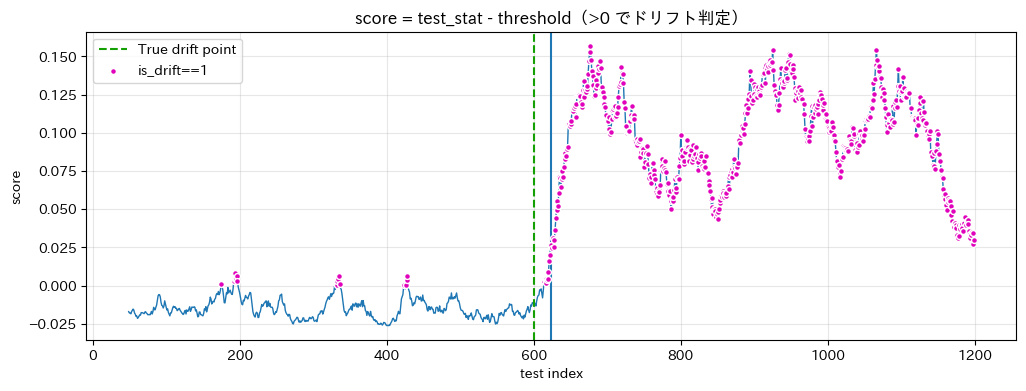

drift==1 の回数 = 602
drift==1 の最初の5個 = [175 192 193 194 195]
drift==1 の最後の5個 = [1195 1196 1197 1198 1199]
検知確定 i_detect = 623


In [21]:
import numpy as np
import matplotlib.pyplot as plt

def stream_full(cd, X_test, window_size, k_consec=1):
    cd.reset_state()
    n = X_test.shape[0]

    test_stat = np.full(n, np.nan, dtype=float)
    threshold = np.full(n, np.nan, dtype=float)
    is_drift  = np.zeros(n, dtype=int)

    consec = 0
    i_detect = None  # 連続判定で確定した検知時刻

    for i, x_t in enumerate(X_test):
        pred = cd.predict(x_t, return_test_stat=True)
        d = pred["data"]

        is_drift[i]  = int(d.get("is_drift", 0))
        test_stat[i] = float(d.get("test_stat", np.nan))
        threshold[i] = float(d.get("threshold", np.nan))

        # 窓が満杯になるまでは「窓=window_size」の判定条件が成立していないので無視
        if i < window_size - 1:
            consec = 0
            continue

        consec = consec + 1 if is_drift[i] == 1 else 0
        if i_detect is None and consec >= k_consec:
            i_detect = i  # ここで確定。ただし記録は最後まで続ける

    score = test_stat - threshold
    score[:window_size-1] = np.nan  # 表示上もウォームアップ区間を消す
    return score, test_stat, threshold, is_drift, i_detect


# 実行（あなたの変数を使用）
score, ts, th, dr, i_detect = stream_full(cd, X_test, window_size=window_size, k_consec=10)

plt.figure(figsize=(12,4))
# drift==1 の全インデックス
idx_drift = np.where(dr == 1)[0]

plt.figure(figsize=(12,4))
plt.plot(score, linewidth=1.0)

# 真の変化点
plt.axvline(T_star, linewidth=1.5, color="#14A002", linestyle="--", label="True drift point")

# drift==1 の箇所を全部プロット（score の値の位置に点を置く）
# score が NaN の区間（ウォームアップ）もあるので、NaN を除外
idx_valid = idx_drift[~np.isnan(score[idx_drift])]
plt.scatter(
    idx_valid,
    score[idx_valid],
    s=18,
    label="is_drift==1",
    color="#E003BB",
    edgecolors="w",
    zorder=3
)

# 検知確定点（k_consec達成）
if i_detect is not None:
    plt.axvline(i_detect, linewidth=1.5)

plt.title("score = test_stat - threshold（>0 でドリフト判定）")
plt.xlabel("test index")
plt.ylabel("score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("drift==1 の回数 =", len(idx_drift))
print("drift==1 の最初の5個 =", idx_drift[:5])
print("drift==1 の最後の5個 =", idx_drift[-5:])
print("検知確定 i_detect =", i_detect)

